# Thesis 

In [60]:
import import_ipynb
from Auxillary_functions import *
import ECoG

### Данные 

Будем рассматривать в качестве выборок несоклько вариантов разбиения данных.
Первый случай: данные об одной обезьяне, снятые в разные дни. Ведь в идеале хочется достичь результата, при котором модель, построенная один раз, работала ,бы для последующих экспериментов.
Второй случай: стандартное разбиение одной выборки на train/test. 

Рассматриваем subdural ECoG for monkey K from 27.05.2009

In [2]:
centers = [(4,1), (6, 1), (8,1),\
           (3, 2), (5, 2), (7,2),\
           (2, 3), (4, 3), (6, 3), (8,3),\
           (1, 4), (3, 4), (5, 4), (7, 4),\
           (2, 5), (4, 5), (6, 5), \
           (1, 6), (3, 6), (5, 6), (7, 6),\
           (2, 7), (4, 7), (6, 7), (8, 7),\
           (1, 8), (3, 8), (5, 8), (7, 8),\
           (2, 9), (4, 9), (6, 9), (8, 9),\
           (1, 10), (3, 10), (5, 10), (7, 10),\
           (2, 11), (4, 11), (6, 11), (8, 11),\
           (1, 12), (3, 12), (5, 12), (7, 12),\
           (2, 13), (4, 13), (6, 13), (8, 13),\
           (1, 14), (3, 14), (5, 14), (7, 14),\
           (2, 15), (4, 15), (6, 15), (8, 15),\
           (1, 16), (3, 16), (5, 16), (7, 16),\
           (2, 17), (4, 17), (6, 17)]

### Raw ECoG 

In [3]:
x,y = ECoG.read_ECoG_from_csv("ECoG.csv","Motion.csv")
data = ECoG.ECoG(x,y,downsample = True)

In [4]:
plt.figure(figsize=(14,6))
plt.plot(x[:,0], x[:,64])
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #64', **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Напряжение, мВ', **axis_font)
plt.grid(True)
#plt.show()
plt.close()

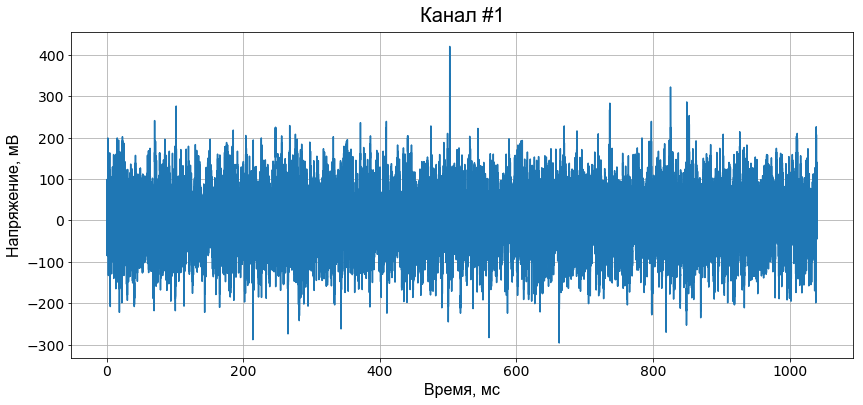

In [5]:
plot_ecog(x[:,0], x[:,1:])

### Гипотезы нормального/гамма распределения 

##### Подготовка данных и параметров 

In [6]:
signal_data = np.array(x)
motion_data = np.array(y)

In [7]:
#simple sync
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
ecog_signal = signal_data[signal_idx]
motion = motion_data[motion_idx]

In [8]:
new_signal = np.array(pd.DataFrame(signal_data).ewm(span = 7).mean())

In [9]:
#ewma sync
ecog_signal = []
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
ecog_signal = new_signal[signal_idx]
motion = motion_data[motion_idx]

In [72]:
N = len(time)

In [73]:
%%time
m = get_mean(ecog_signal[:N, 1:], time[:N])
d = get_disp(m, ecog_signal[:N, 1:], time[:N])

Wall time: 13.3 s


In [12]:
%%time
#Calcuate bivariate normal distribution for each moment of time

mv = []
for i in range(len(m)):
    mv.append(multivariate_normal([m[i, 0], m[i, 1]], [[d[i,0], 0], [0, d[i, 1]]]))


Wall time: 42.8 s


In [13]:
%%time
intens = get_intens(m, d, mv, ecog_signal[:N, 1:], time[:N])

Wall time: 7.1 s


##### Нормальное распределение

###### Не нормализованное, с поправкой на интенсивность

In [55]:
intens_multiplier = True
mae = []
mse = []
r2 = []
for channel in range(1,64):
    point = centers[channel]
    rv = []

    for j in range(len(mv)):
            p = mv[j].pdf(point)
            if intens_multiplier == True:
                rv.append(p*intens[j])
            else:
                rv.append(p)
                
    mae.append(mean_absolute_error(rv, ecog_signal[:, channel]))
    mse.append(mean_squared_error(rv, ecog_signal[:, channel]))
    r2.append(r2_score(rv, ecog_signal[:, channel]))

In [56]:
print ('mae: ', np.array(mae).mean(), '\n mse:', np.array(mse).mean(), '\n r2-score: ', np.array(r2).mean())

mae:  90.69906449386306 
 mse: 22129.043490038814 
 r2-score:  -0.046715082489768606


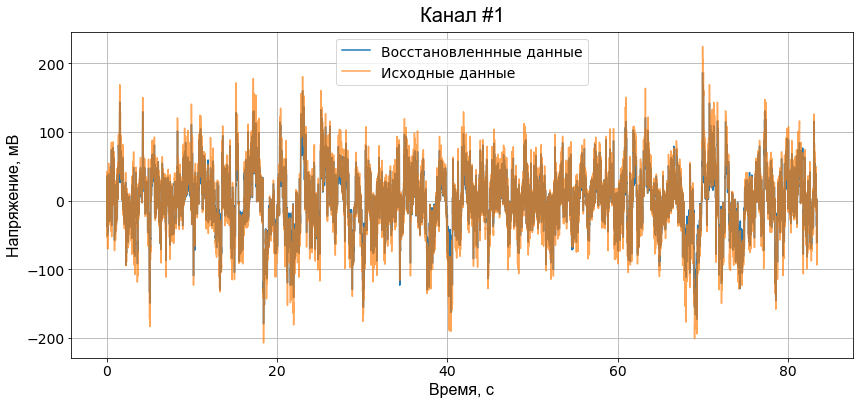

mae:  8.801380310691902 
 mse: 150.5424462034644 
 r2-score:  0.9196552944605539


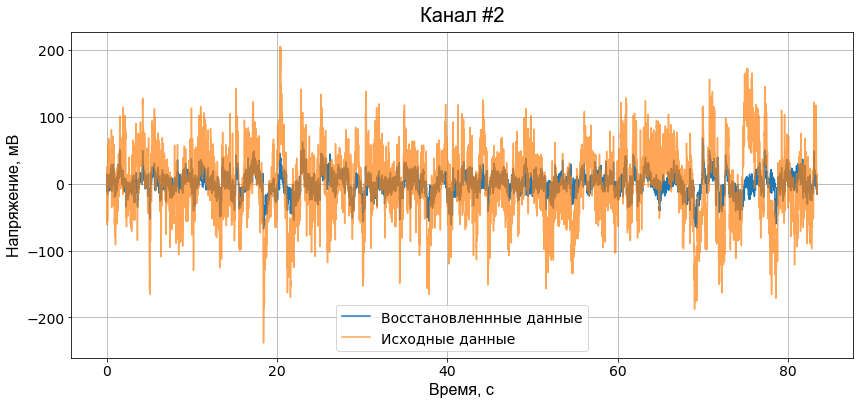

mae:  33.8926099431583 
 mse: 1850.7613719371423 
 r2-score:  -6.770259222960473


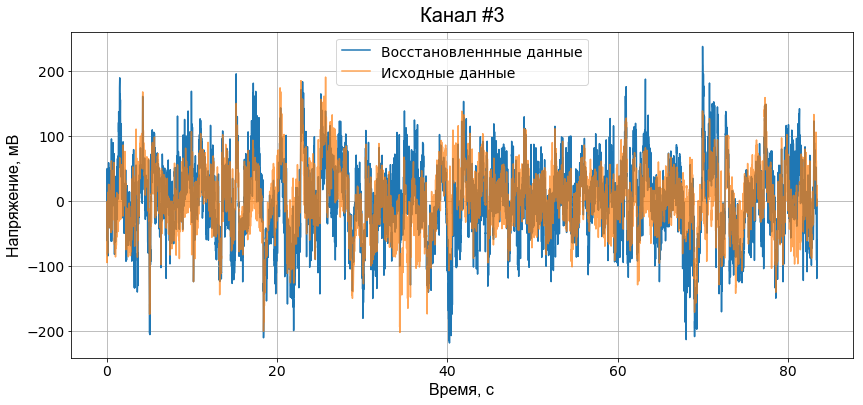

mae:  35.99993021416363 
 mse: 2076.104508098083 
 r2-score:  0.438261246745


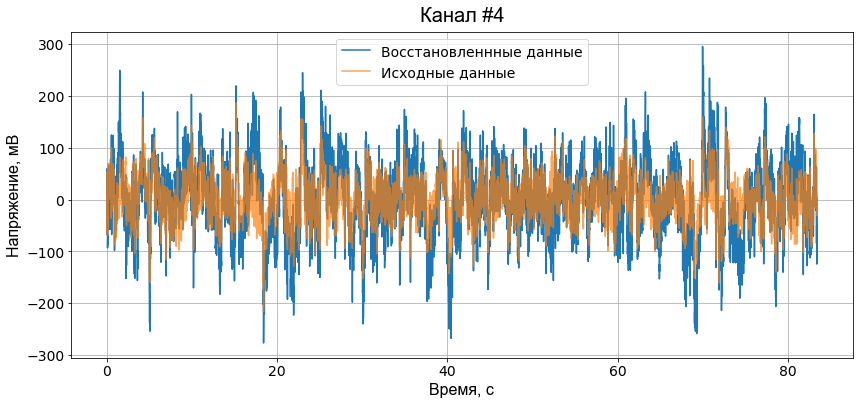

mae:  37.28353966618378 
 mse: 2212.970120175298 
 r2-score:  0.5848906666179353


In [46]:
#N = len(time)
intens_multiplier = True
N = 10000
for channel in range(1, 5):
    point = centers[channel]
    rv = []

    for j in range(len(mv[:N])):
            p = mv[j].pdf(point)
            if intens_multiplier == True:
                rv.append(p*intens[j])
            else:
                rv.append(p)
                
    plt.figure(figsize=(14,6))
    plt.plot(time[:N], rv,   label = 'Восстановленнные данные')
    plt.plot(time[:N], ecog_signal[:N, channel],  alpha = 0.7, label = 'Исходные данные')
    plt.xticks( fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    plt.title('Канал #%i' %channel, **title_font)
    plt.xlabel('Время, с', **axis_font)
    plt.ylabel('Напряжение, мВ', **axis_font)
    plt.legend(prop={'size': 14})
    plt.grid(True)
    plt.show()
    print ('mae: ', mean_absolute_error(rv, ecog_signal[:N, channel]),\
           '\n mse:', mean_squared_error(rv, ecog_signal[:N, channel]), \
           '\n r2-score: ', r2_score(rv, ecog_signal[:N, channel]))

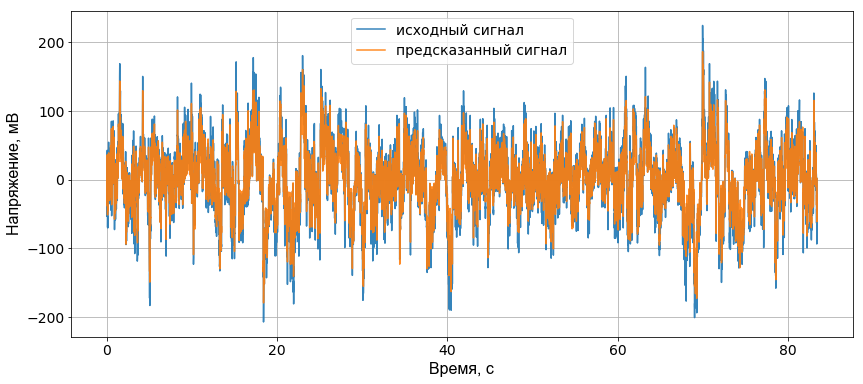

In [21]:
    plt.figure(figsize=(14,6))
    
    plt.plot(time[:N], ecog_signal[:N, channel],  alpha = 0.9, label = 'исходный сигнал')
    plt.plot(time[:N], rv, alpha = 0.9, label = 'предсказанный сигнал')
    plt.xticks( fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
   #plt.title('Канал #%i' %channel, **title_font)
    plt.xlabel('Время, с', **axis_font)
    plt.ylabel('Напряжение, мВ', **axis_font)
    plt.legend(prop={'size': 14})
    plt.grid(True)
    plt.show()

In [58]:
from scipy.stats import pearsonr
np.corrcoef(ecog_signal[:N, channel],rv )

array([[1.        , 0.99196526],
       [0.99196526, 1.        ]])

###### Распределение висхарта

###### Ненормализованное, с поправкой на интенсивность

In [31]:
intens_multiplier = True
mae = []
mse = []
r2 = []
for channel in range(1,64):
    point = centers[channel]
    g_d = []

    for j in range(len(m)):
        p = wishart.pdf(point, 2, [[m[j, 0], 0], [0, m[j, 1]]])
        if intens_multiplier == True:
            g_d.append(p*intens[j])
        else:
            g_d.append(p)    
    mae.append(mean_absolute_error(g_d, ecog_signal[:, channel]))
    mse.append(mean_squared_error(g_d, ecog_signal[:, channel]))
    r2.append(r2_score(g_d, ecog_signal[:, channel]))

KeyboardInterrupt: 

In [21]:
print ('mae: ', np.array(mae).mean(), '\n mse:', np.array(mse).mean(), '\n r2-score: ', np.array(r2).mean())

mae:  35.55287435441659 
 mse: 2217.0855439790075 
 r2-score:  -1108.0467099696064


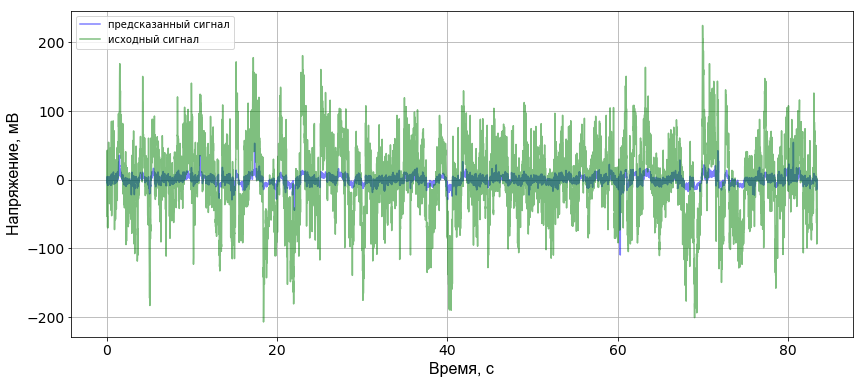

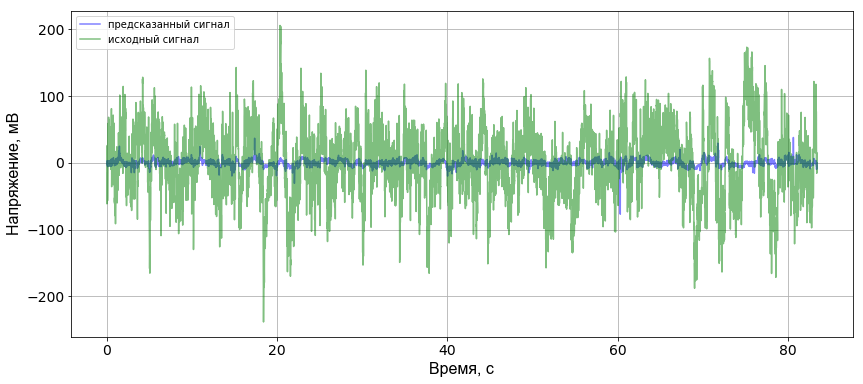

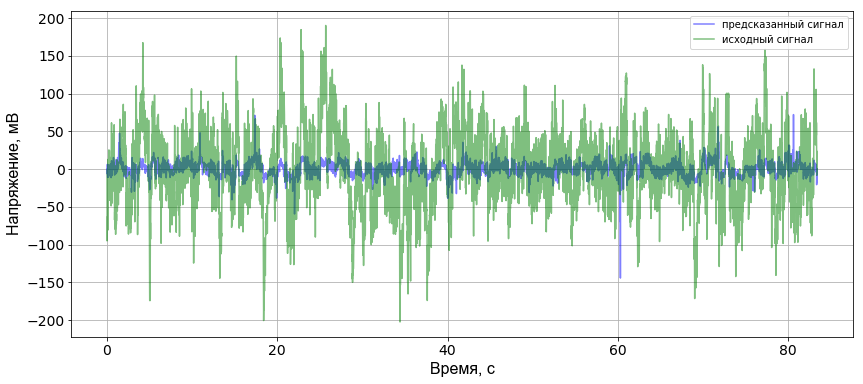

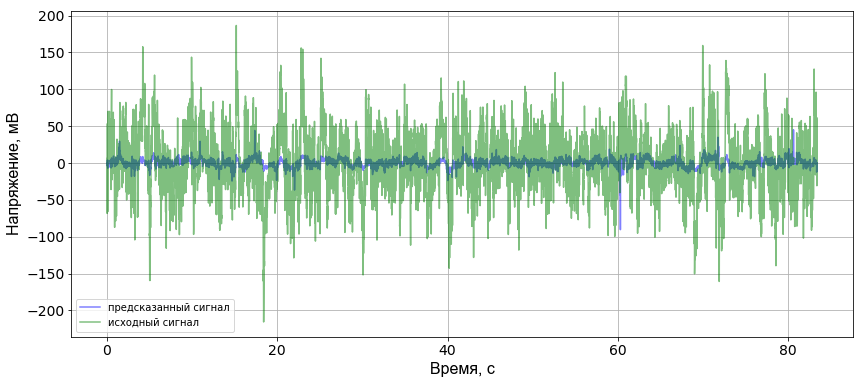

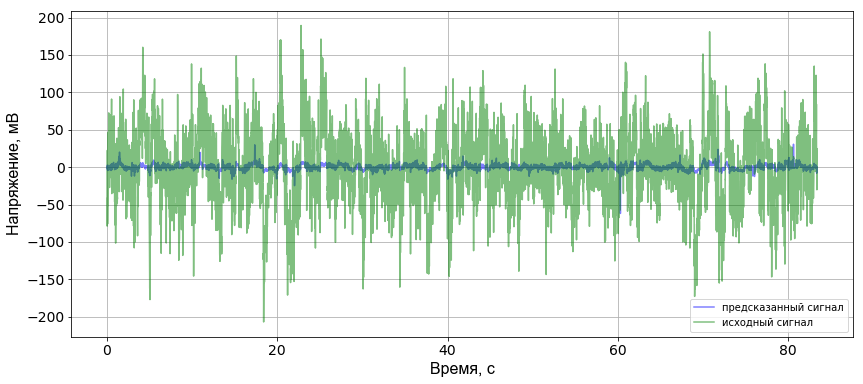

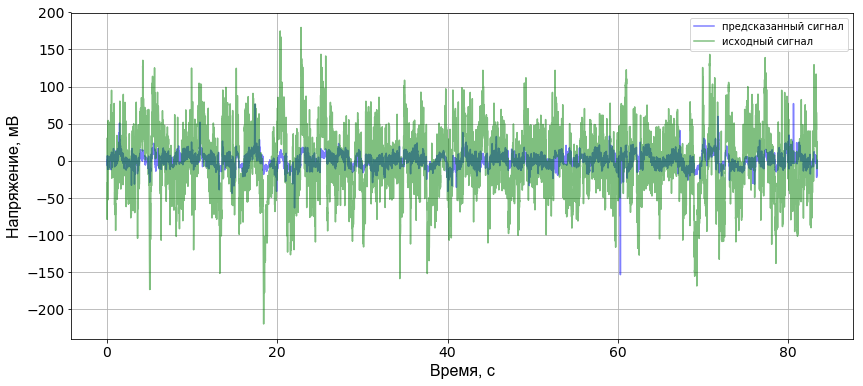

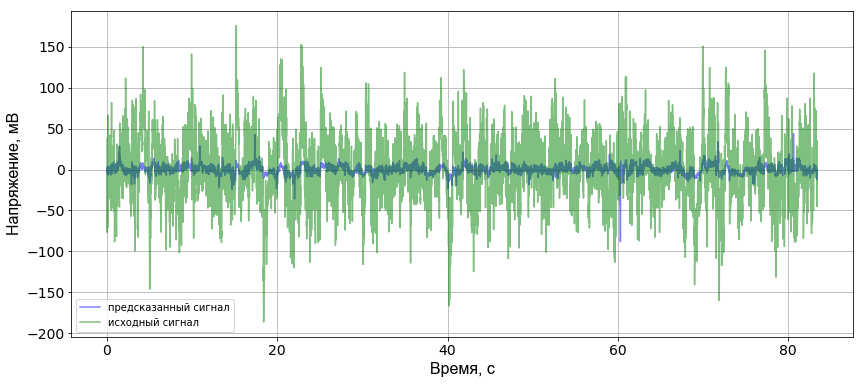

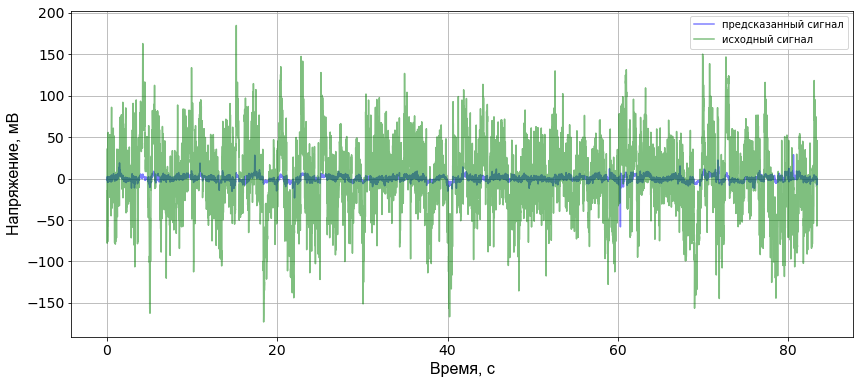

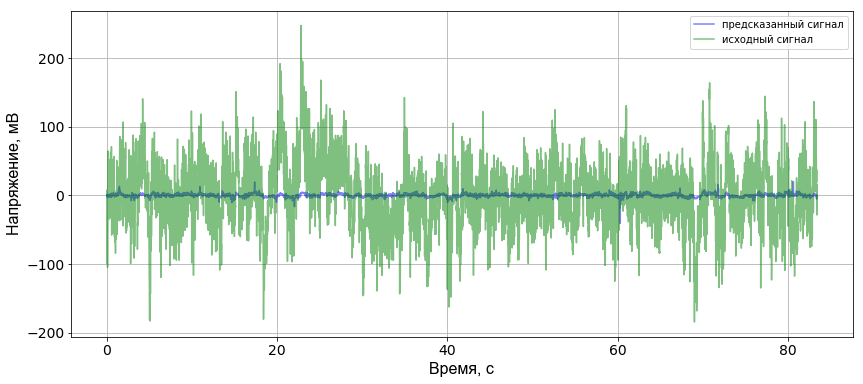

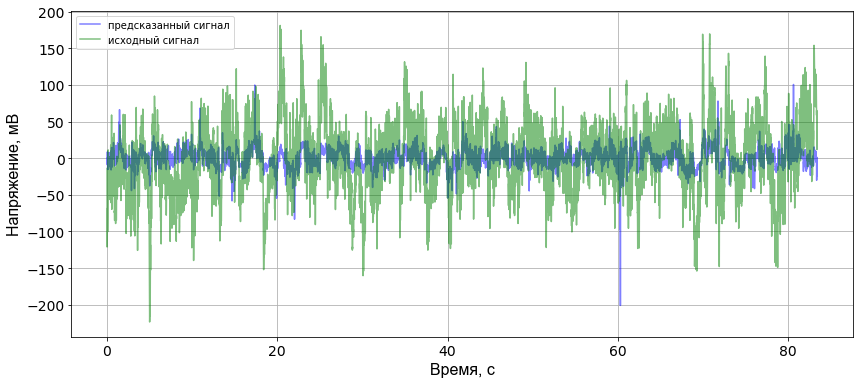

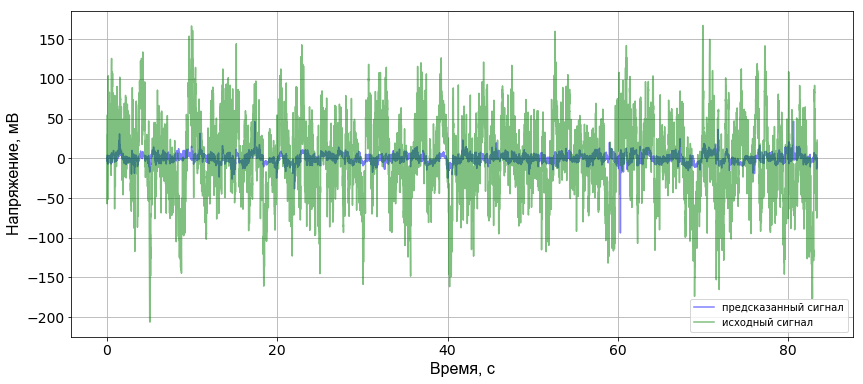

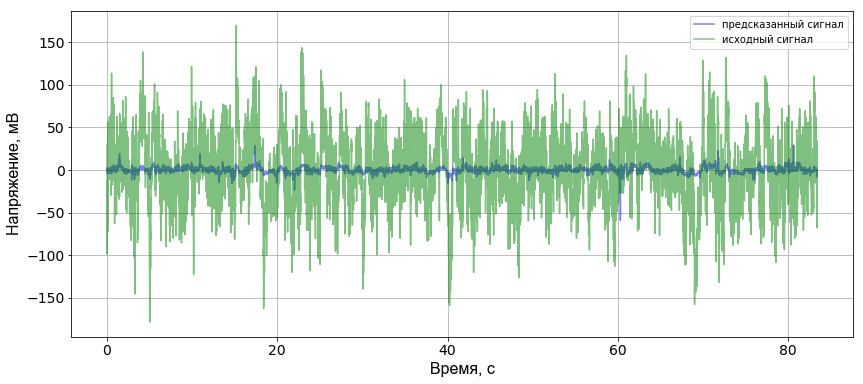

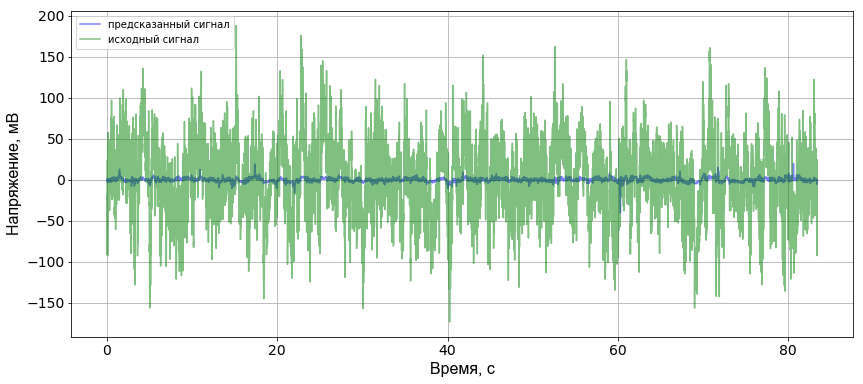

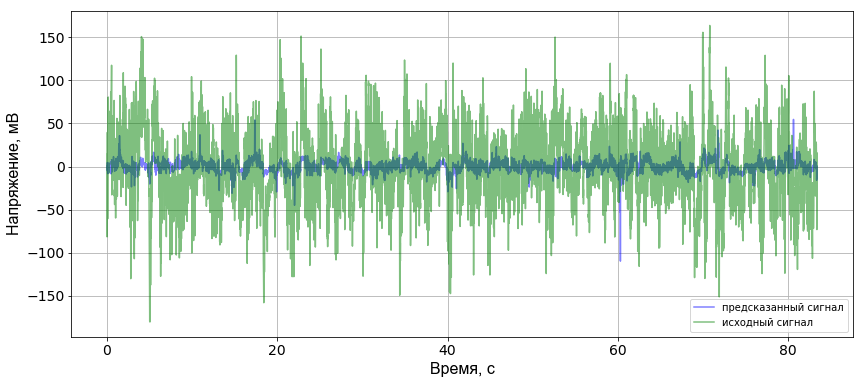

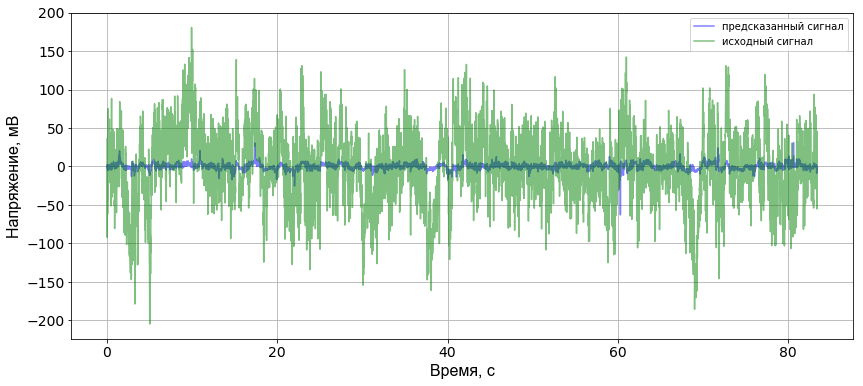

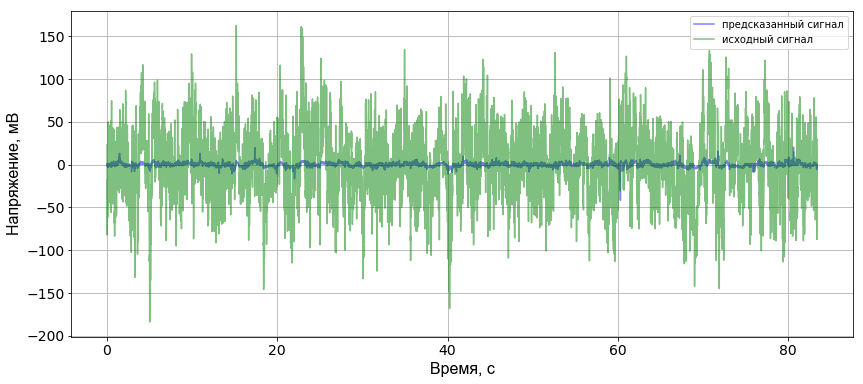

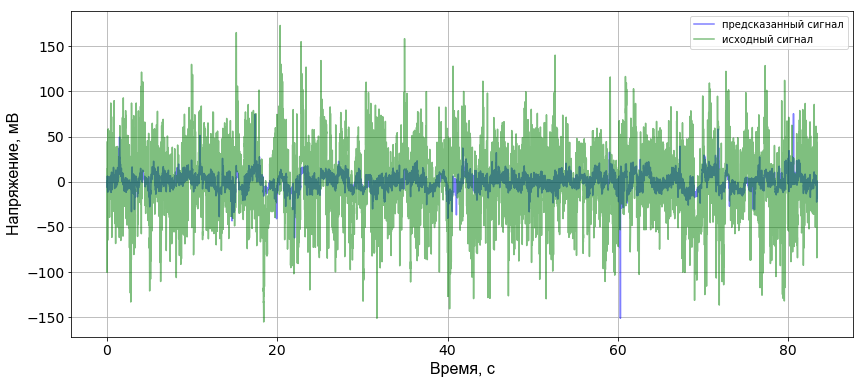

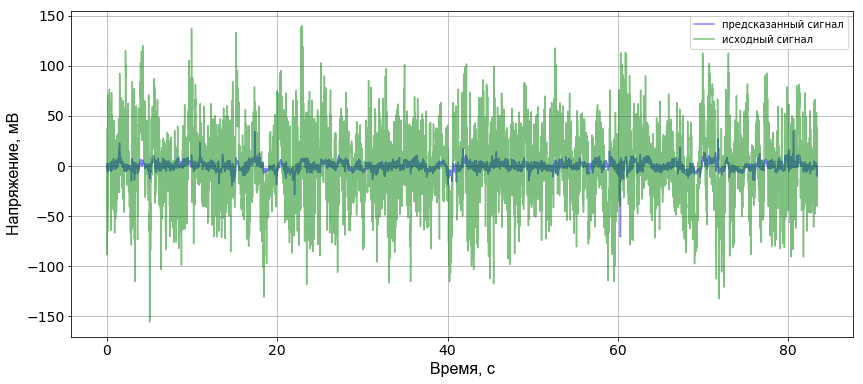

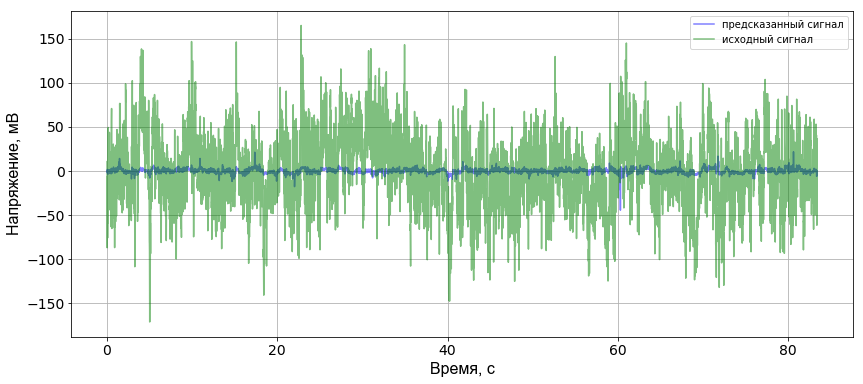

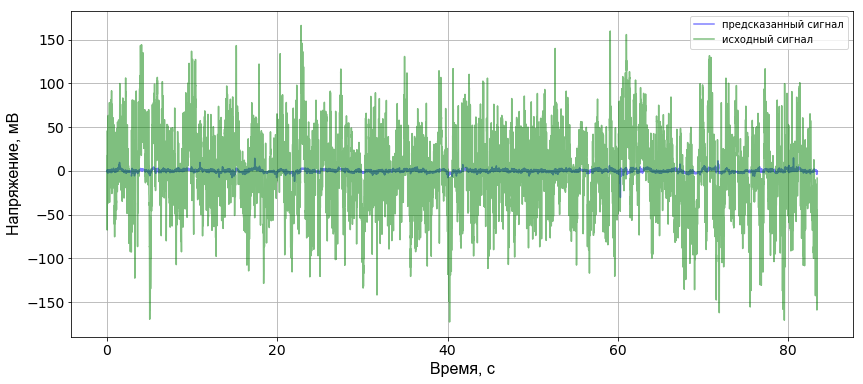

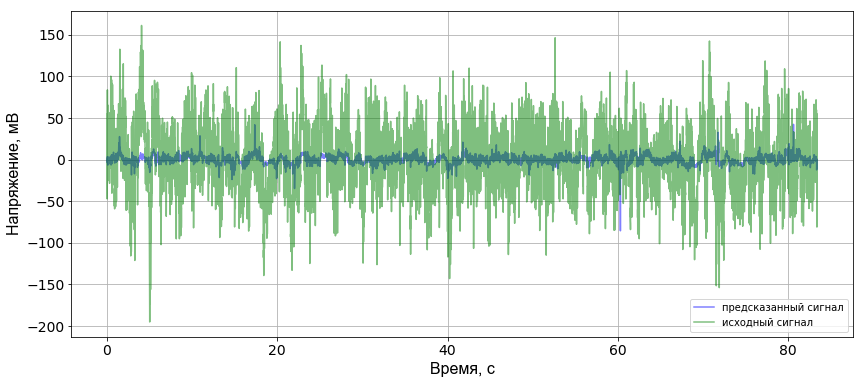

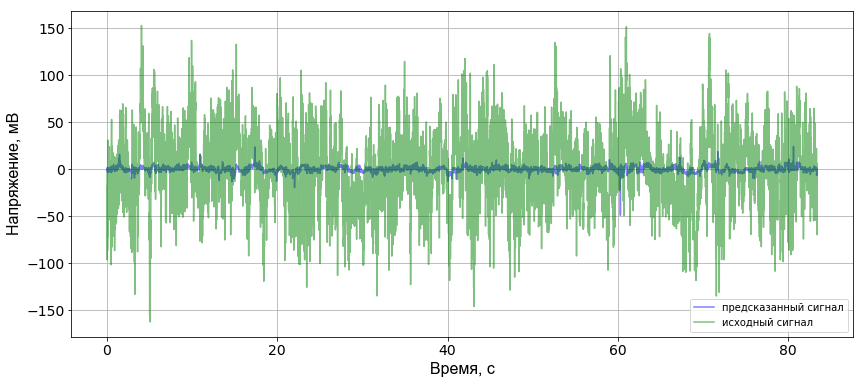

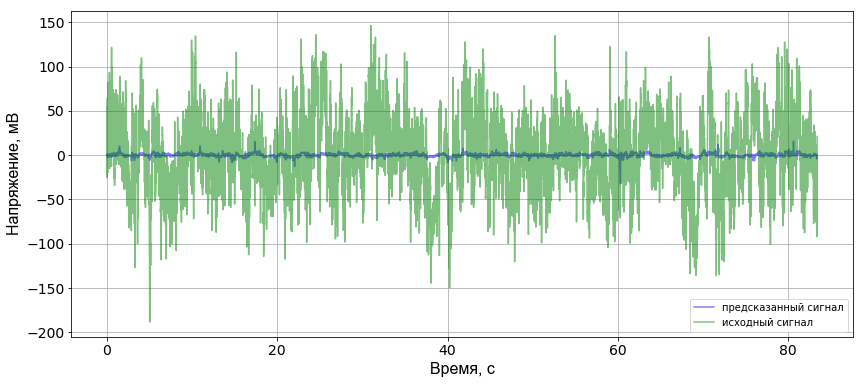

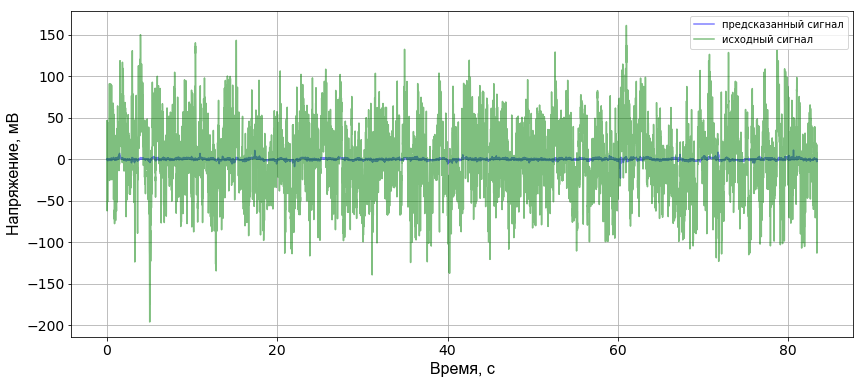

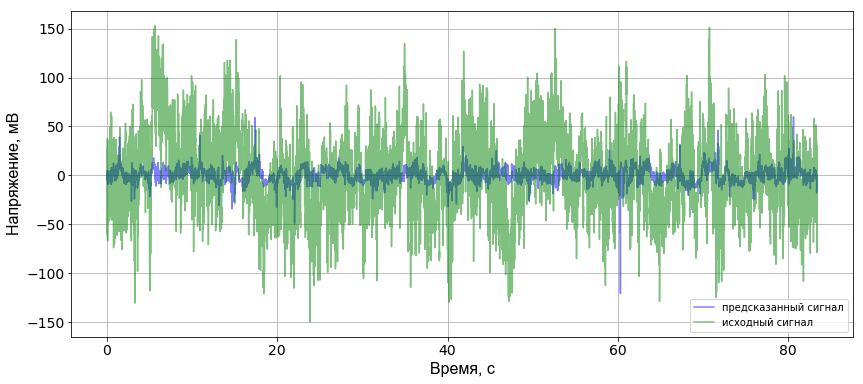

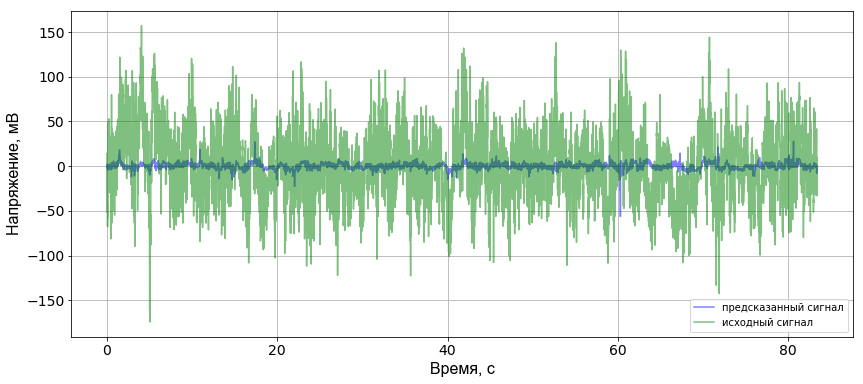

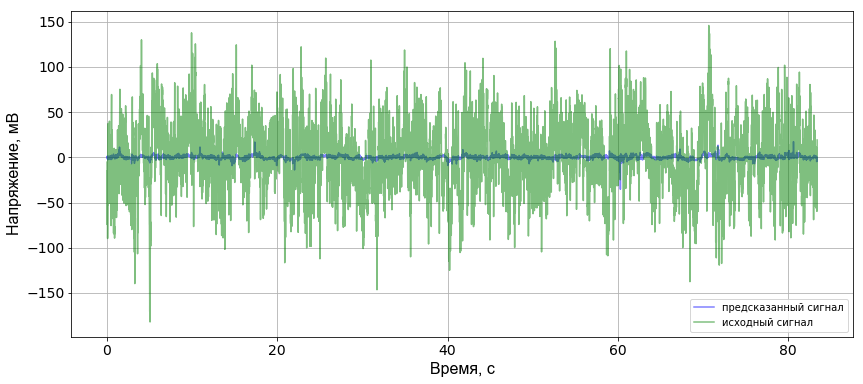

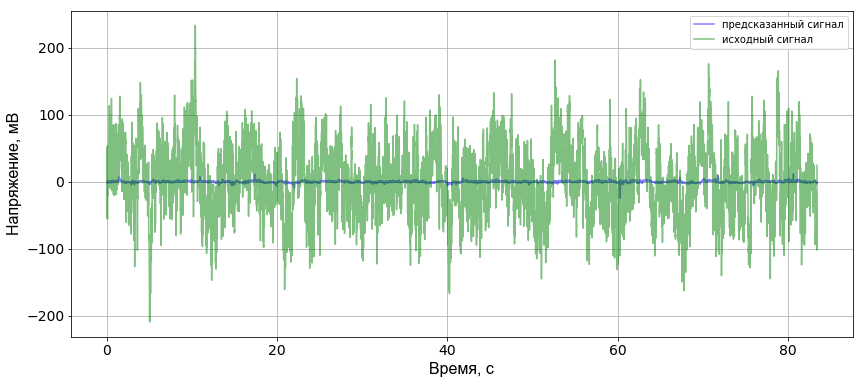

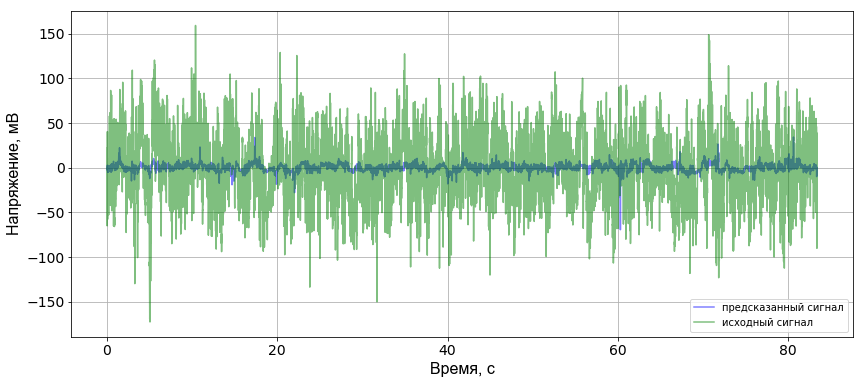

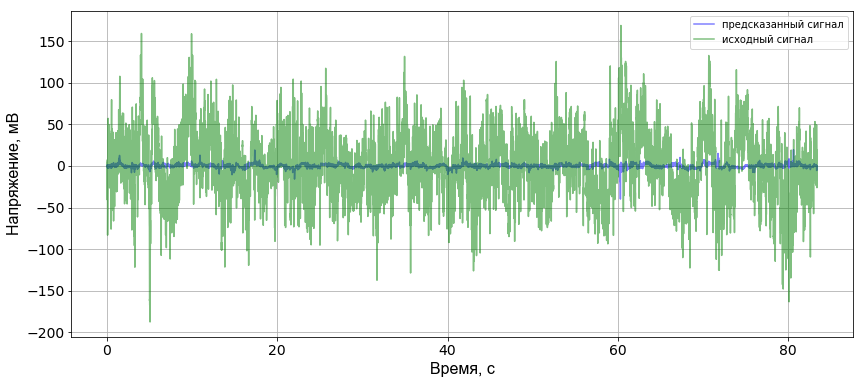

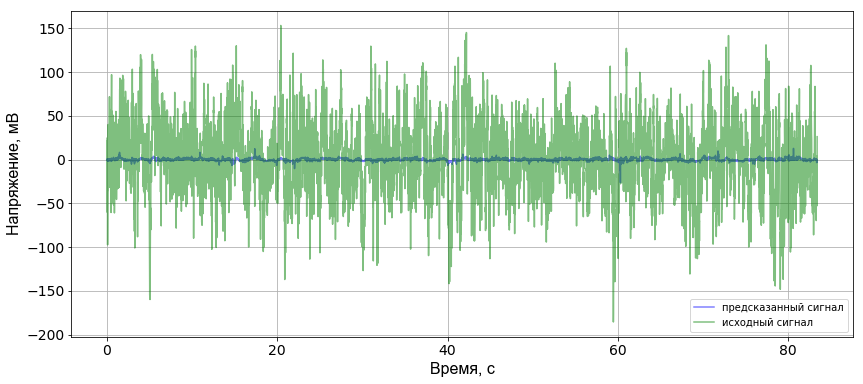

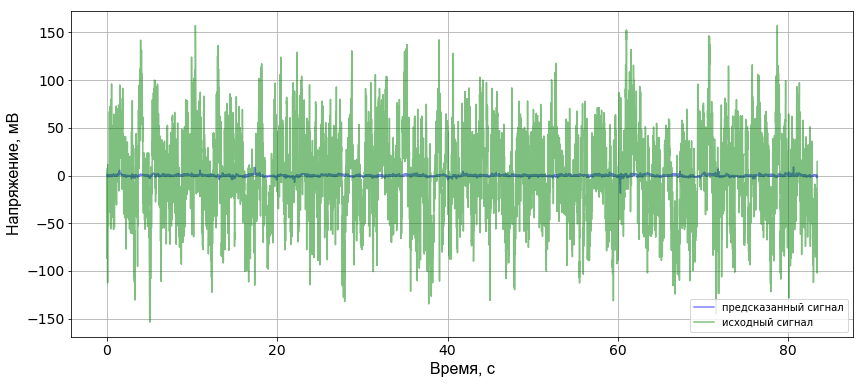

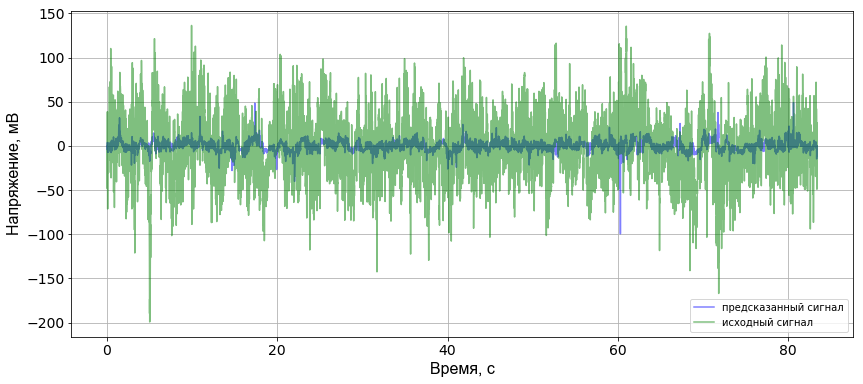

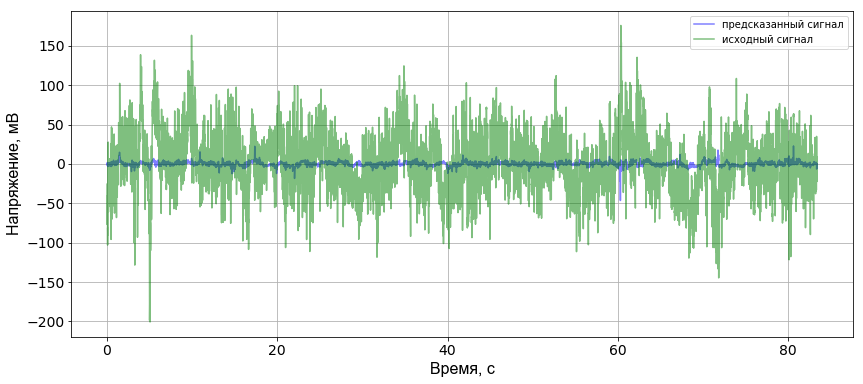

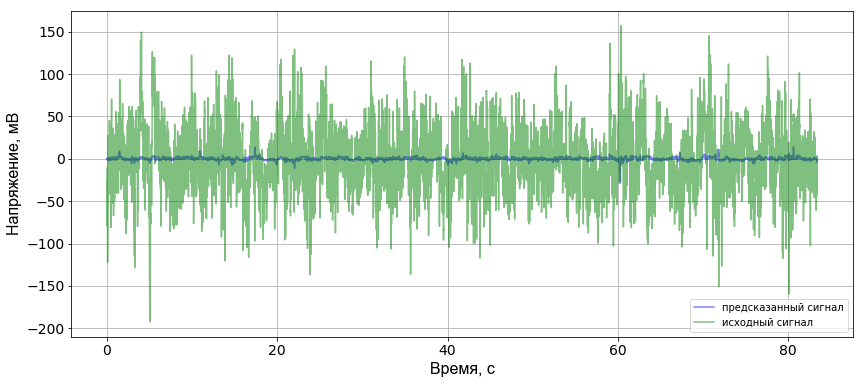

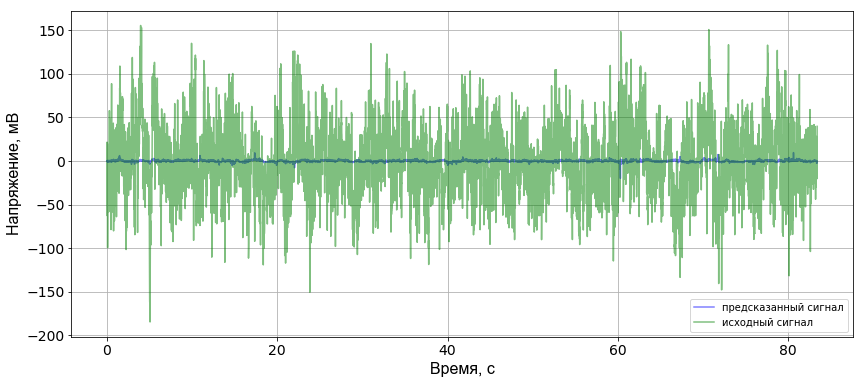

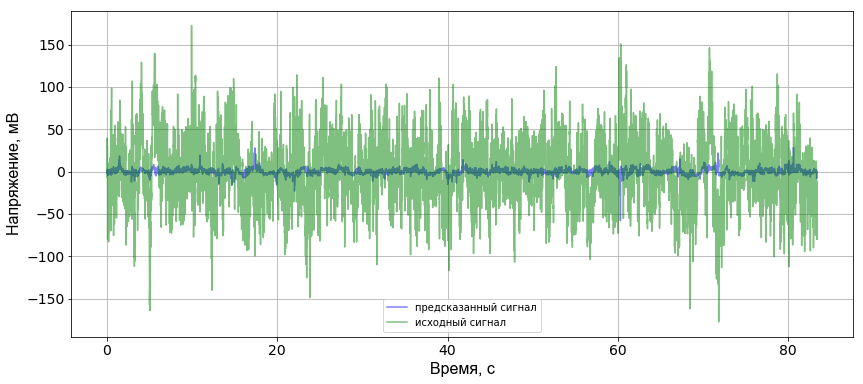

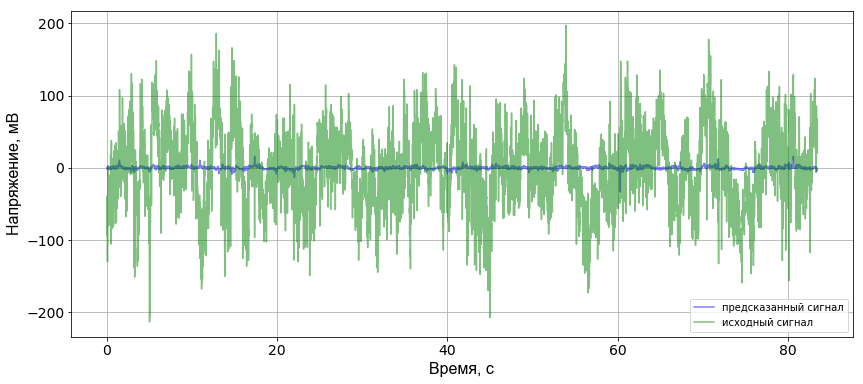

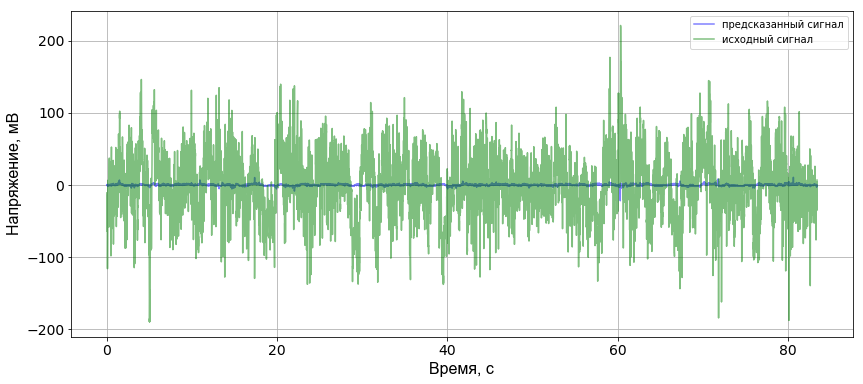

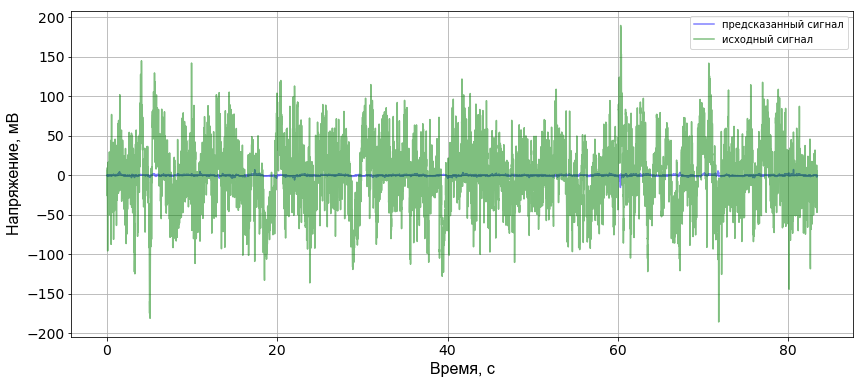

KeyboardInterrupt: 

In [32]:
#N = len(time)
N = 10000
for channel in range(1, 64):
    point = centers[channel]
    g_d = []
    for j in range(len(m[:N])):
        p = wishart.pdf(point, 2, [[m[j, 0], 0], [0, m[j, 1]]])
        if intens_multiplier == True:
            g_d.append(p*intens[j])
        else:
            g_d.append(p)

    plt.figure(figsize=(14,6))
    plt.plot(time[:N], g_d, color='blue', alpha = 0.5, label = 'предсказанный сигнал')
    plt.plot(time[:N], ecog_signal[:N, channel], color='green', alpha = 0.5, label = 'исходный сигнал')
    plt.xticks( fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    #plt.title('Канал #%i' %channel, **title_font)
    plt.xlabel('Время, с', **axis_font)
    plt.ylabel('Напряжение, мВ', **axis_font)
    plt.legend()
    plt.grid(True)
    plt.show()
    ('mae: ', mean_absolute_error(rv, ecog_signal[:N, channel]),\
           '\n mse:', mean_squared_error(rv, ecog_signal[:N, channel]), \
           '\n r2-score: ', r2_score(rv, ecog_signal[:N, channel]))

##### Построение регресси для предсказани движения по параметрам вышеуказанных локальных моделей

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [48]:
X = np.c_[m, d, intens]

In [52]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [57]:
Xr_train, Xr_test, yr_train, yr_test, ttr, ttt = train_test_split(X, motion[:, 1:], time, test_size=0.35, shuffle = False)
model = LinearRegression(n_jobs = -1)


model = RandomForestRegressor(n_estimators=500,  n_jobs=-1, random_state=42)
model.fit(Xr_train,yr_train)
Y_pred = model.predict(Xr_test)


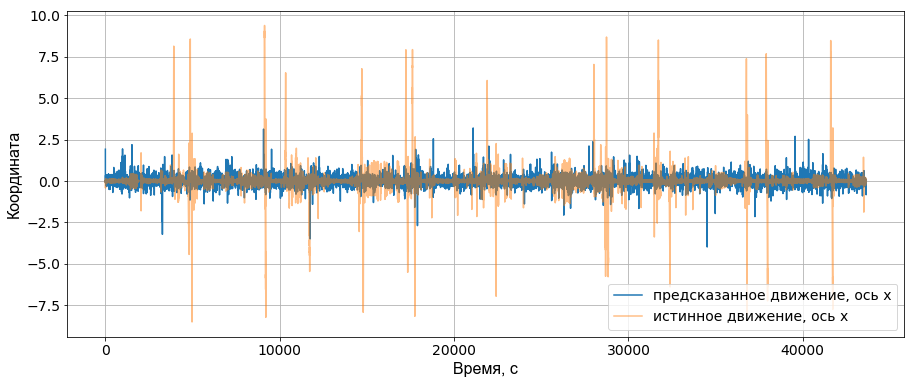

In [58]:
plt.figure(figsize = (15,6))
plt.plot(Y_pred[:, 1],label = 'предсказанное движение, ось х')
plt.plot(np.array(yr_test)[:, 1],  alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right', prop={'size': 14})
plt.grid(True)
plt.show()

In [59]:

print(' mae: ', mean_absolute_error(yr_test[:,:], Y_pred),'\n mse: ',mean_squared_error(yr_test[:,:], Y_pred),'\n r2-score: ',\
      r2_score(yr_test[:,:],Y_pred))

 mae:  0.21243065802072925 
 mse:  0.41971470641043096 
 r2-score:  -0.03754139165638348


### Линейная модель экога по параметрам среднего, дисперсии и интенсивности

In [64]:
n_sample = int(len(signal_data)/3)

In [31]:
channel = 14
y_train = signal_data[:n_sample, channel]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, ecog_signal[:, 1:], test_size = 0.33, shuffle= False)

In [66]:
reg = LinearRegression().fit(X_train, y_train)

In [67]:
y_pred = reg.predict(X_test)
#reg.coef_

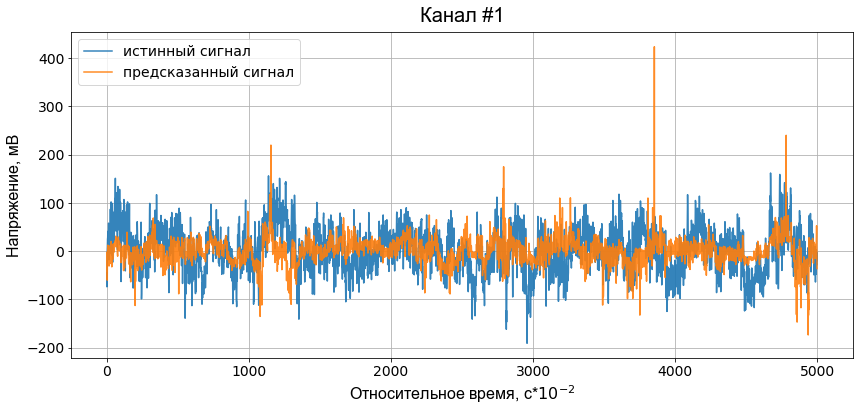

In [68]:
#N = len(time)
N = 5000
plt.figure(figsize = (14, 6))
plt.plot(range(len(y_pred[:N, 1])),y_test[:N,1], alpha = 0.9, label = 'истинный сигнал')
plt.plot(range(len(y_pred[:N, 1])),y_pred[:N,1], alpha = 0.9, label = 'предсказанный сигнал')

plt.legend(prop={'size': 14})
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Относительное время, с*$10^{-2}$', **axis_font)
plt.ylabel('Напряжение, мВ', **axis_font)
plt.grid(True)
plt.show()

In [69]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  34.72677180759003 
 mse:  2128.6019588567688 
 r2-score:  0.10262551498410771


In [70]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor( criterion='mse', max_depth=20, min_samples_split=2, min_samples_leaf=1,\
                                 min_weight_fraction_leaf=0.0, max_features='auto', \
                                 max_leaf_nodes=None,bootstrap=True, n_jobs=-1, random_state=42, warm_start=False)

In [71]:
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


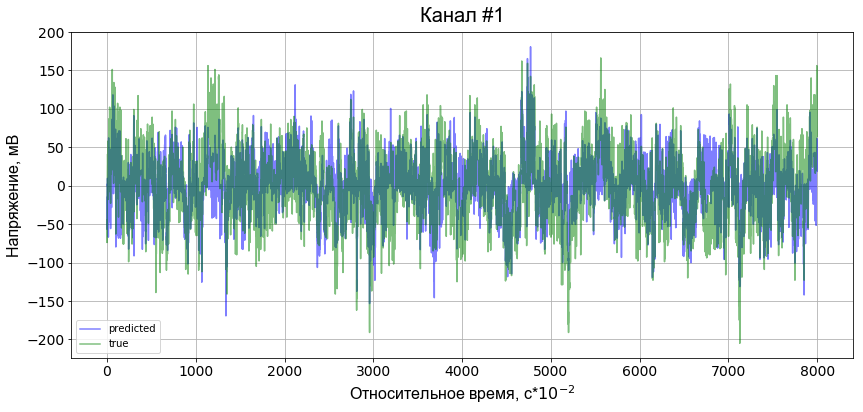

In [72]:
N = 8000
plt.figure(figsize = (14, 6))
plt.plot(range(len(y_pred[:N])),y_pred[:N,1], alpha = 0.5, color = 'blue', label = 'predicted')
plt.plot(range(len(y_pred[:N])),y_test[:N,1], alpha = 0.5, color = 'green', label = 'true')
plt.legend()
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('время, с*$10^{-2}$', **axis_font)
plt.ylabel('Напряжение, мВ', **axis_font)
plt.grid(True)
plt.show()

In [40]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  36.80079585532296 
 mse:  2356.3653110145974 
 r2-score:  -0.08722094368425143


In [41]:
import gc
gc.collect()

17984

In [42]:
np.corrcoef(y_test[:10000], y_pred[:10000])

array([[ 1.        ,  0.84460212,  0.67932733, ...,  0.14341898,
         0.21188895,  0.18176624],
       [ 0.84460212,  1.        ,  0.75874535, ...,  0.20383771,
         0.38292729,  0.31401878],
       [ 0.67932733,  0.75874535,  1.        , ..., -0.04684406,
         0.01502519,  0.17863297],
       ...,
       [ 0.14341898,  0.20383771, -0.04684406, ...,  1.        ,
         0.33997444,  0.50712299],
       [ 0.21188895,  0.38292729,  0.01502519, ...,  0.33997444,
         1.        ,  0.3532526 ],
       [ 0.18176624,  0.31401878,  0.17863297, ...,  0.50712299,
         0.3532526 ,  1.        ]])

####  Эксперимент с расширением признакового пространства парой статистик


In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
m_s = []
d_s = []
min_s = []
max_s = []
for i in range(len(m)):
    m_s.append(ecog_signal[i, 1:].mean())
    d_s.append(ecog_signal[i, 1:].std())
    min_s.append(min(ecog_signal[i, 1:]))   
    max_s.append(max(ecog_signal[i, 1:]))   

In [45]:
X = np.c_[m, d, intens, m_s, d_s, min_s, max_s]

In [46]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


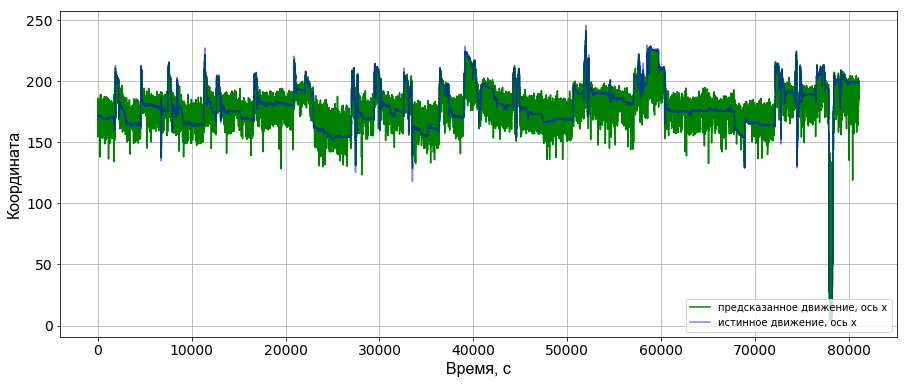

In [47]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, motion[:, 1:], test_size=0.35, shuffle = False)
'''model = LinearRegression(n_jobs = -1)
model.fit(Xr_train,yr_train)
y_pred = model.predict(Xr_train)
'''
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor( criterion='mse', max_depth=50, min_samples_split=2, min_samples_leaf=1,\
                                 min_weight_fraction_leaf=0.0, max_features='auto', \
                                 max_leaf_nodes=None,bootstrap=True, n_jobs=-1, random_state=42, warm_start=False)

model_rf.fit(Xr_train, yr_train)
y_pred = model_rf.predict(Xr_train)
plt.figure(figsize = (15,6))
plt.plot(y_pred[:, 0], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(yr_train[:, 0], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [48]:
from sklearn.metrics import r2_score
r2_score(yr_test[:,1],y_pred[:, 1])

ValueError: Found input variables with inconsistent numbers of samples: [43643, 81050]

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
clf = Ridge(alpha=0.0001, normalize=True,  solver="auto", random_state=42)

In [ ]:
clf.coef_

In [ ]:
X = np.c_[m, d, intens]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, motion[:, 1:], test_size=0.35, shuffle = False)
clf.fit(Xr_train,yr_train[:, 0])
Y_pred = clf.predict(Xr_test)

plt.figure(figsize = (15,6))
plt.plot(time[-(len(Y_pred)):],Y_pred[:], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(time[-(len(Y_pred)):],yr_test[:, 0], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(ecog_signal, ecog_signal, time, test_size = 0.33, random_state = 42, shuffle = False)


##### Gamma params 1d

In [ ]:
a = []
b = []
c = []
intens = []
for i in range(len(ecog_signal)):
    step = ecog_signal[i, 1:]
    x = sum(step)/64 
    s = 1/63*(sum((step - x)**2))
    m3 = 1/64*(sum((step - x)**3))
    a.append(4*s**3/(m3**2))
    b.append(0.5*m3/s)
    c.append(x-2*s**2/m3)
    intens.append(np.max(step))

In [ ]:
params = np.c_[a, b, c, intens]
X_train, X_test = train_test_split(params, test_size = 0.33, random_state = 42, shuffle = False)

In [ ]:
from sklearn.linear_model import Lasso
lr = RandomForestRegressor
lr.fit(X_train, y_train)

In [ ]:
Y_pred = lr.predict(X_test)

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(Y_pred[:1000, 1], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(y_test[:1000, 1], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #1', **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [ ]:
print(' mae: ', mean_absolute_error(y_test, Y_pred),'\n mse: ',mean_squared_error(y_test, Y_pred),'\n r2-score: ',\
      r2_score(y_test,Y_pred))

##### gauss and AR

In [69]:
N = 100
#idx - n AR
for j in range(len(signal_idx)):
    if signal_idx[j]>=N:
        mm = j
        break
mm

12

In [64]:
from statsmodels.tsa.vector_ar.var_model import VAR
# fit model
params = []
data = ecog_signal
#data = data0
#data = data2 
for i in signal_idx[mm:10000]:
    data1 = data[i-N:i+1]
    model = VAR(data1)
    model_fit = model.fit()
    params.append(np.array(model_fit.params)[0])#.mean(axis = 1))

In [110]:
params = np.array(params)
XX = np.c_[params, m[mm:10000], d[mm:10000], intens[mm:10000]]
X_train, X_test, y_train, y_test, ttr, ttt = train_test_split(XX, motion1[mm:10000], time[mm:10000], test_size = 0.33, random_state = 42, shuffle = False)

In [111]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [112]:
y_pred = lr.predict(X_test)

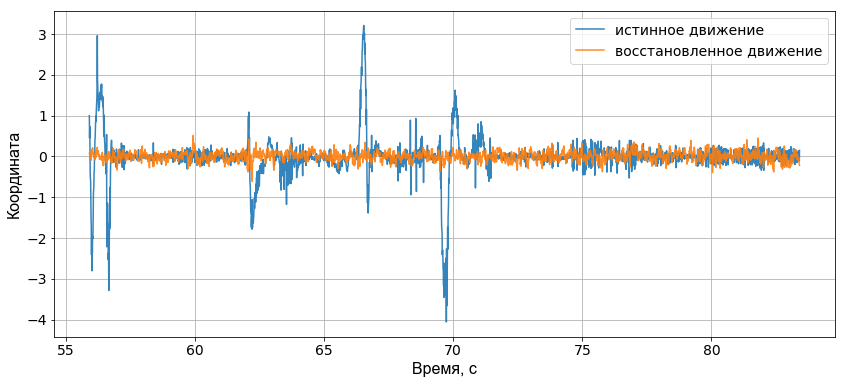

In [113]:
plt.figure(figsize = (14, 6))
plt.plot(ttt,y_test[:,1], alpha = 0.9, label = 'истинное движение')
plt.plot(ttt,y_pred[:,1], alpha = 0.9, label = 'восстановленное движение')

plt.legend(prop={'size': 14})
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.grid(True)
plt.show()

In [114]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  0.35741539499994796 
 mse:  0.7486430665376407 
 r2-score:  -0.04113734251575115


In [96]:
X_train, X_test, y_train, y_test, ttr, ttt = train_test_split(XX, ecog_signal[mm:10000], time[mm:10000], test_size = 0.33, random_state = 42, shuffle = False)

In [98]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

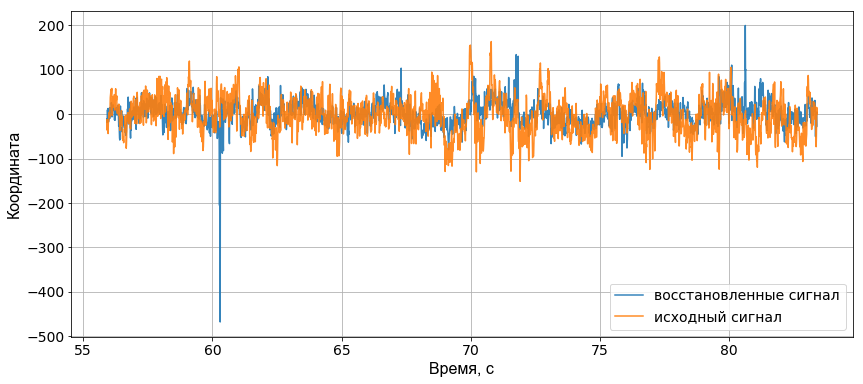

In [105]:
plt.figure(figsize = (14, 6))
plt.plot(ttt,y_pred[:,14], alpha = 0.9, label = 'восстановленные сигнал')
plt.plot(ttt,y_test[:,14], alpha = 0.9, label = 'исходный сигнал')


plt.legend(prop={'size': 14})
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.grid(True)
plt.show()

In [106]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  36.15159266034936 
 mse:  2238.0331898737963 
 r2-score:  -0.5322123600762634
